<a href="https://colab.research.google.com/github/aksu143/Capstone/blob/dev%2Fcapstone/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
import os

In [8]:
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from keras.models import load_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Activation, RepeatVector, Dropout, BatchNormalization, Flatten, Bidirectional, TimeDistributed, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

pd.set_option('display.max_colwidth', 200)

import random
random.seed(0)
import re
import string
import warnings
warnings.filterwarnings("ignore")
from numpy import array, argmax, random, take

nltk.download('stopwords',quiet=True)
nltk.download('wordnet', quiet=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
europarl_en_dataset = open('/content/drive/MyDrive/Colab Notebooks/europarl-v7_en.txt', encoding='utf-8')
europarl_de_dataset = open('/content/drive/MyDrive/Colab Notebooks/europarl-v7_de.txt', encoding='utf-8')

commoncrawl_en_dataset = open('/content/drive/MyDrive/Colab Notebooks/commoncrawl_en.txt', encoding='utf-8')
commoncrawl_de_dataset = open('/content/drive/MyDrive/Colab Notebooks/commoncrawl_de.txt', encoding='utf-8')

newscommentary_en_dataset = open('/content/drive/MyDrive/Colab Notebooks/news-commentary-v9_en.txt', encoding='utf-8')
newscommentary_de_dataset = open('/content/drive/MyDrive/Colab Notebooks/news-commentary-v9_de.txt', encoding='utf-8')


In [15]:
europarl_en = europarl_en_dataset.readlines()
europarl_de = europarl_de_dataset.readlines()

commoncrawl_en = commoncrawl_en_dataset.readlines()
commoncrawl_de = commoncrawl_de_dataset.readlines()

newscommentary_en = newscommentary_en_dataset.readlines()
newscommentary_de = newscommentary_de_dataset.readlines()

# Creating the dataframe of the source files

europarl_en_df = pd.DataFrame(europarl_en, columns=['English'])
europarl_de_df = pd.DataFrame(europarl_de, columns = ['German'])

commoncrawl_en_df = pd.DataFrame(commoncrawl_en, columns=['English'])
commoncrawl_de_df = pd.DataFrame(commoncrawl_de, columns = ['German'])

newscommentary_en_df = pd.DataFrame(newscommentary_en, columns=['English'])
newscommentary_de_df = pd.DataFrame(newscommentary_de, columns = ['German'])

In [16]:
europarl_en_df.head(5)

,English
0,Resumption of the session\n
1,"I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant fest..."
2,"Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.\n"
3,"You have requested a debate on this subject in the course of the next few days, during this part-session.\n"
4,"In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the vari..."


In [17]:
europarl_de_df.head(5)

,German
0,Wiederaufnahme der Sitzungsperiode\n
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie..."
2,"Wie Sie feststellen konnten, ist der gefürchtete ""Millenium-Bug "" nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.\n"
3,Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.\n
4,"Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schwei..."


In [18]:
commoncrawl_en_df.head(5)

,English
0,iron cement is a ready for use paste which is laid as a fillet by putty knife or finger in the mould edges (corners) of the steel ingot mould.\n
1,"iron cement protects the ingot against the hot, abrasive steel casting process.\n"
2,"a fire restant repair cement for fire places, ovens, open fireplaces etc.\n"
3,Construction and repair of highways and...\n
4,An announcement must be commercial character.\n


In [19]:
commoncrawl_de_df.head(5)

,German
0,"iron cement ist eine gebrauchs-fertige Paste, die mit einem Spachtel oder den Fingern als Hohlkehle in die Formecken (Winkel) der Stahlguss -Kokille aufgetragen wird.\n"
1,"Nach der Aushärtung schützt iron cement die Kokille gegen den heissen, abrasiven Stahlguss .\n"
2,"feuerfester Reparaturkitt für Feuerungsanlagen, Öfen, offene Feuerstellen etc.\n"
3,Der Bau und die Reparatur der Autostraßen...\n
4,die Mitteilungen sollen den geschäftlichen kommerziellen Charakter tragen.\n


In [20]:
newscommentary_en_df.head(5)

,English
0,"$10,000 Gold?\n"
1,SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.\n
2,"Lately, with gold prices up more than 300% over the last decade, it is harder than ever.\n"
3,"Just last December, fellow economists Martin Feldstein and Nouriel Roubini each penned op-eds bravely questioning bullish market sentiment, sensibly pointing out gold’s risks.\n"
4,Wouldn’t you know it?\n


In [21]:
newscommentary_de_df.head(5)

,German
0,Steigt Gold auf 10.000 Dollar?\n
1,"SAN FRANCISCO – Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen.\n"
2,"In letzter Zeit allerdings ist dies schwieriger denn je, ist doch der Goldpreis im letzten Jahrzehnt um über 300 Prozent angestiegen.\n"
3,"Erst letzten Dezember verfassten meine Kollegen Martin Feldstein und Nouriel Roubini Kommentare, in denen sie mutig die vorherrschende optimistische Marktstimmung hinterfragten und sehr überlegt a..."
4,"Und es kam, wie es kommen musste.\n"


In [22]:
print(europarl_en_df.shape)
print(europarl_de_df.shape)

print(commoncrawl_en_df.shape)
print(commoncrawl_de_df.shape)

print(newscommentary_en_df.shape)
print(newscommentary_de_df.shape)

(1920209, 1)
(1920209, 1)
(2399123, 1)
(2399123, 1)
(201995, 1)
(201854, 1)


In [23]:
newscommentary_de_duplicate = newscommentary_de_df[newscommentary_de_df.duplicated()]
newscommentary_en_duplicate = newscommentary_en_df[newscommentary_en_df.duplicated()]

In [24]:
newscommentary_de_df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
201849,False
201850,False
201851,False
201852,False


In [25]:
newscommentary_en_df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
201990,False
201991,False
201992,False
201993,False


In [26]:
newscommentary_df = newscommentary_en_df.join(newscommentary_de_df)

newscommentary_df.head(5)

,English,German
0,"$10,000 Gold?\n",Steigt Gold auf 10.000 Dollar?\n
1,SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.\n,"SAN FRANCISCO – Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen.\n"
2,"Lately, with gold prices up more than 300% over the last decade, it is harder than ever.\n","In letzter Zeit allerdings ist dies schwieriger denn je, ist doch der Goldpreis im letzten Jahrzehnt um über 300 Prozent angestiegen.\n"
3,"Just last December, fellow economists Martin Feldstein and Nouriel Roubini each penned op-eds bravely questioning bullish market sentiment, sensibly pointing out gold’s risks.\n","Erst letzten Dezember verfassten meine Kollegen Martin Feldstein und Nouriel Roubini Kommentare, in denen sie mutig die vorherrschende optimistische Marktstimmung hinterfragten und sehr überlegt a..."
4,Wouldn’t you know it?\n,"Und es kam, wie es kommen musste.\n"


In [27]:
newscommentary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201995 entries, 0 to 201994
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   English  201995 non-null  object
 1   German   201854 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [28]:
commoncrawl_df = commoncrawl_en_df.join(commoncrawl_de_df)

commoncrawl_df.head(5)

,English,German
0,iron cement is a ready for use paste which is laid as a fillet by putty knife or finger in the mould edges (corners) of the steel ingot mould.\n,"iron cement ist eine gebrauchs-fertige Paste, die mit einem Spachtel oder den Fingern als Hohlkehle in die Formecken (Winkel) der Stahlguss -Kokille aufgetragen wird.\n"
1,"iron cement protects the ingot against the hot, abrasive steel casting process.\n","Nach der Aushärtung schützt iron cement die Kokille gegen den heissen, abrasiven Stahlguss .\n"
2,"a fire restant repair cement for fire places, ovens, open fireplaces etc.\n","feuerfester Reparaturkitt für Feuerungsanlagen, Öfen, offene Feuerstellen etc.\n"
3,Construction and repair of highways and...\n,Der Bau und die Reparatur der Autostraßen...\n
4,An announcement must be commercial character.\n,die Mitteilungen sollen den geschäftlichen kommerziellen Charakter tragen.\n


In [29]:
commoncrawl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2399123 entries, 0 to 2399122
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   English  object
 1   German   object
dtypes: object(2)
memory usage: 36.6+ MB


In [30]:
europarl_df = europarl_en_df.join(europarl_de_df)

europarl_df.head(5)

,English,German
0,Resumption of the session\n,Wiederaufnahme der Sitzungsperiode\n
1,"I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant fest...","Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie..."
2,"Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.\n","Wie Sie feststellen konnten, ist der gefürchtete ""Millenium-Bug "" nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.\n"
3,"You have requested a debate on this subject in the course of the next few days, during this part-session.\n",Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.\n
4,"In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the vari...","Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schwei..."


In [31]:
europarl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920209 entries, 0 to 1920208
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   English  object
 1   German   object
dtypes: object(2)
memory usage: 29.3+ MB


In [32]:
translation_df = pd.concat([newscommentary_df,commoncrawl_df, europarl_df])

translation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4521327 entries, 0 to 1920208
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   English  object
 1   German   object
dtypes: object(2)
memory usage: 103.5+ MB


In [33]:
translation_df.shape

(4521327, 2)

In [34]:
translation_df.head()

,English,German
0,"$10,000 Gold?\n",Steigt Gold auf 10.000 Dollar?\n
1,SAN FRANCISCO – It has never been easy to have a rational conversation about the value of gold.\n,"SAN FRANCISCO – Es war noch nie leicht, ein rationales Gespräch über den Wert von Gold zu führen.\n"
2,"Lately, with gold prices up more than 300% over the last decade, it is harder than ever.\n","In letzter Zeit allerdings ist dies schwieriger denn je, ist doch der Goldpreis im letzten Jahrzehnt um über 300 Prozent angestiegen.\n"
3,"Just last December, fellow economists Martin Feldstein and Nouriel Roubini each penned op-eds bravely questioning bullish market sentiment, sensibly pointing out gold’s risks.\n","Erst letzten Dezember verfassten meine Kollegen Martin Feldstein und Nouriel Roubini Kommentare, in denen sie mutig die vorherrschende optimistische Marktstimmung hinterfragten und sehr überlegt a..."
4,Wouldn’t you know it?\n,"Und es kam, wie es kommen musste.\n"


In [35]:
translation_df.isna()

,English,German
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
1920204,False,False
1920205,False,False
1920206,False,False
1920207,False,False


In [36]:
translation_df.isna().sum()

,0
English,0
German,141


In [37]:
translation_df.duplicated().sum()

45016

**Model 2:** Basic RNN Model with Short Length Sentence

In [38]:
translation_df_reduced = translation_df.sample(frac = 0.005)

**Data Cleaning**

In [39]:
translation_df_reduced = translation_df_reduced[translation_df_reduced.English.str.count('\s+').lt(6)]

translation_df_reduced = translation_df_reduced.astype(str).applymap(lambda x: str(x.replace('\n','')))

translation_df_reduced['German'] = translation_df_reduced['German'].str.strip()

translation_df_reduced['English'] = translation_df_reduced['English'].str.strip()

translation_df_reduced = translation_df_reduced.replace('', np.nan)

translation_df_reduced = translation_df_reduced.dropna()

In [40]:
translation_df_reduced.count('index')

,0
English,402
German,402


In [41]:
translation_df_reduced.head(10)

,English,German
59624,Assad’s regime is doomed.,"Was eine Marktwirtschaft wirklich zu einer Marktwirtschaft werden lässt, so dachte ich, ist die Tatsache, dass man immer auf eine Texaco-, BP-, Elf - oder Statoil-Tankstelle trifft oder einen Seve..."
4639,"Thank you, Minister.","Vielen Dank, Herr Minister!"
714796,That is indeed good news.,Das ist eine wirklich gute Nachricht.
60330,Overexposure hurts.,"Niemand kennt ihre Ansichten zum Nahen Osten, zum Terrorismus, der nuklearen Abschreckung und der internationalen Sicherheit."
1876532,Approval of the Minutes,Genehmigung des Protokolls
150771,"Thank you, Commissioner Verheugen.","Vielen Dank, Herr Kommissar Verheugen!"
689808,.,.
1129529,Thank you very much.,Vielen Dank.
1174598,So much the better!,Umso besser!
1899523,The situation is completely surreal.,Das ist purer Surrealismus.


In [42]:
np.savetxt('/content/drive/MyDrive/Colab Notebooks/combined_eng_ger.txt', translation_df_reduced.to_numpy(), delimiter='\t', fmt='%s')


**Pre Processing - Dataset suitable to be used for AIML model learning**

In [43]:
def load_doc(filename):

    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()

    # close the file
    file.close()

    return text

In [44]:
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [45]:
from unicodedata import normalize

# Function to clean a list of lines

def clean_pairs(lines):
    cleaned = list()

    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))

    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)

    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')

            # tokenize on white space
            line = line.split()

            # convert to lowercase
            line = [word.lower() for word in line]

            # remove punctuation from each token
            line = [word.translate(table) for word in line]

            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]

            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]

            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [46]:
from pickle import load,dump
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [48]:
filename = '/content/drive/MyDrive/Colab Notebooks/combined_eng_ger.txt'

doc = load_doc(filename)

# Calling to_pair function to split dat into english-german pairs
pairs = to_pairs(doc)

# Calling clean_pair function to clean the sentences
clean_pairs = clean_pairs(pairs)

# Calling save_clean_data function to save clean pairs into file
save_clean_data(clean_pairs, '/content/drive/MyDrive/Colab Notebooks/german-english.pkl')

Saved: /content/drive/MyDrive/Colab Notebooks/german-english.pkl


In [49]:
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [50]:
print(clean_pairs.size)

804


In [51]:
from numpy.random import shuffle

# Loading clean dataset
raw_dataset = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/german-english.pkl')

# Reducing dataset size
n_sentences = clean_pairs.size
dataset = raw_dataset[:n_sentences, :]

# Randomly shuffling the dataset
shuffle(dataset)

# Generating train and test datasets
train, test = train_test_split(dataset, test_size=0.25, random_state=1)

# Saving clean, train, test dataset into pickle file
save_clean_data(dataset, '/content/drive/MyDrive/Colab Notebooks/english-german-both.pkl')
save_clean_data(train, '/content/drive/MyDrive/Colab Notebooks/english-german-train.pkl')
save_clean_data(test, '/content/drive/MyDrive/Colab Notebooks/english-german-test.pkl')

Saved: /content/drive/MyDrive/Colab Notebooks/english-german-both.pkl
Saved: /content/drive/MyDrive/Colab Notebooks/english-german-train.pkl
Saved: /content/drive/MyDrive/Colab Notebooks/english-german-test.pkl


In [52]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [53]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [54]:
def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)

    # padding sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')

    return X

In [55]:
from keras.utils import to_categorical

# Function to convert vectors into binary matrix

def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [57]:
dataset = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/english-german-both.pkl')
train = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/english-german-train.pkl')
test = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/english-german-test.pkl')

In [59]:
eng_tokenizer_rnn = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer_rnn.word_index) + 1
eng_length_rnn = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length_rnn))

# Preparing German tokenizer

ger_tokenizer_rnn = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer_rnn.word_index) + 1
ger_length_rnn = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length_rnn))

English Vocabulary Size: 531
English Max Length: 5
German Vocabulary Size: 907
German Max Length: 47


In [60]:
# prepare training data
trainX = encode_sequences(ger_tokenizer_rnn, ger_length_rnn, train[:, 1])
trainY = encode_sequences(eng_tokenizer_rnn, eng_length_rnn, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare validation data
testX = encode_sequences(ger_tokenizer_rnn, ger_length_rnn, test[:, 1])
testY = encode_sequences(eng_tokenizer_rnn, eng_length_rnn, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

**Model Design**

In [61]:
def define_simple_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(SimpleRNN(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(SimpleRNN(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [62]:
model_translate_RNN = define_simple_model(ger_vocab_size, eng_vocab_size, ger_length_rnn, eng_length_rnn, 256)

In [63]:
model_translate_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
model_translate_RNN.build(input_shape=(None, 3))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 3, 256)              │         232,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 5, 256)              │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 5, 531)              │         136,467 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 631,315 (2.41 MB)

 Trainable params: 631,315 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

None


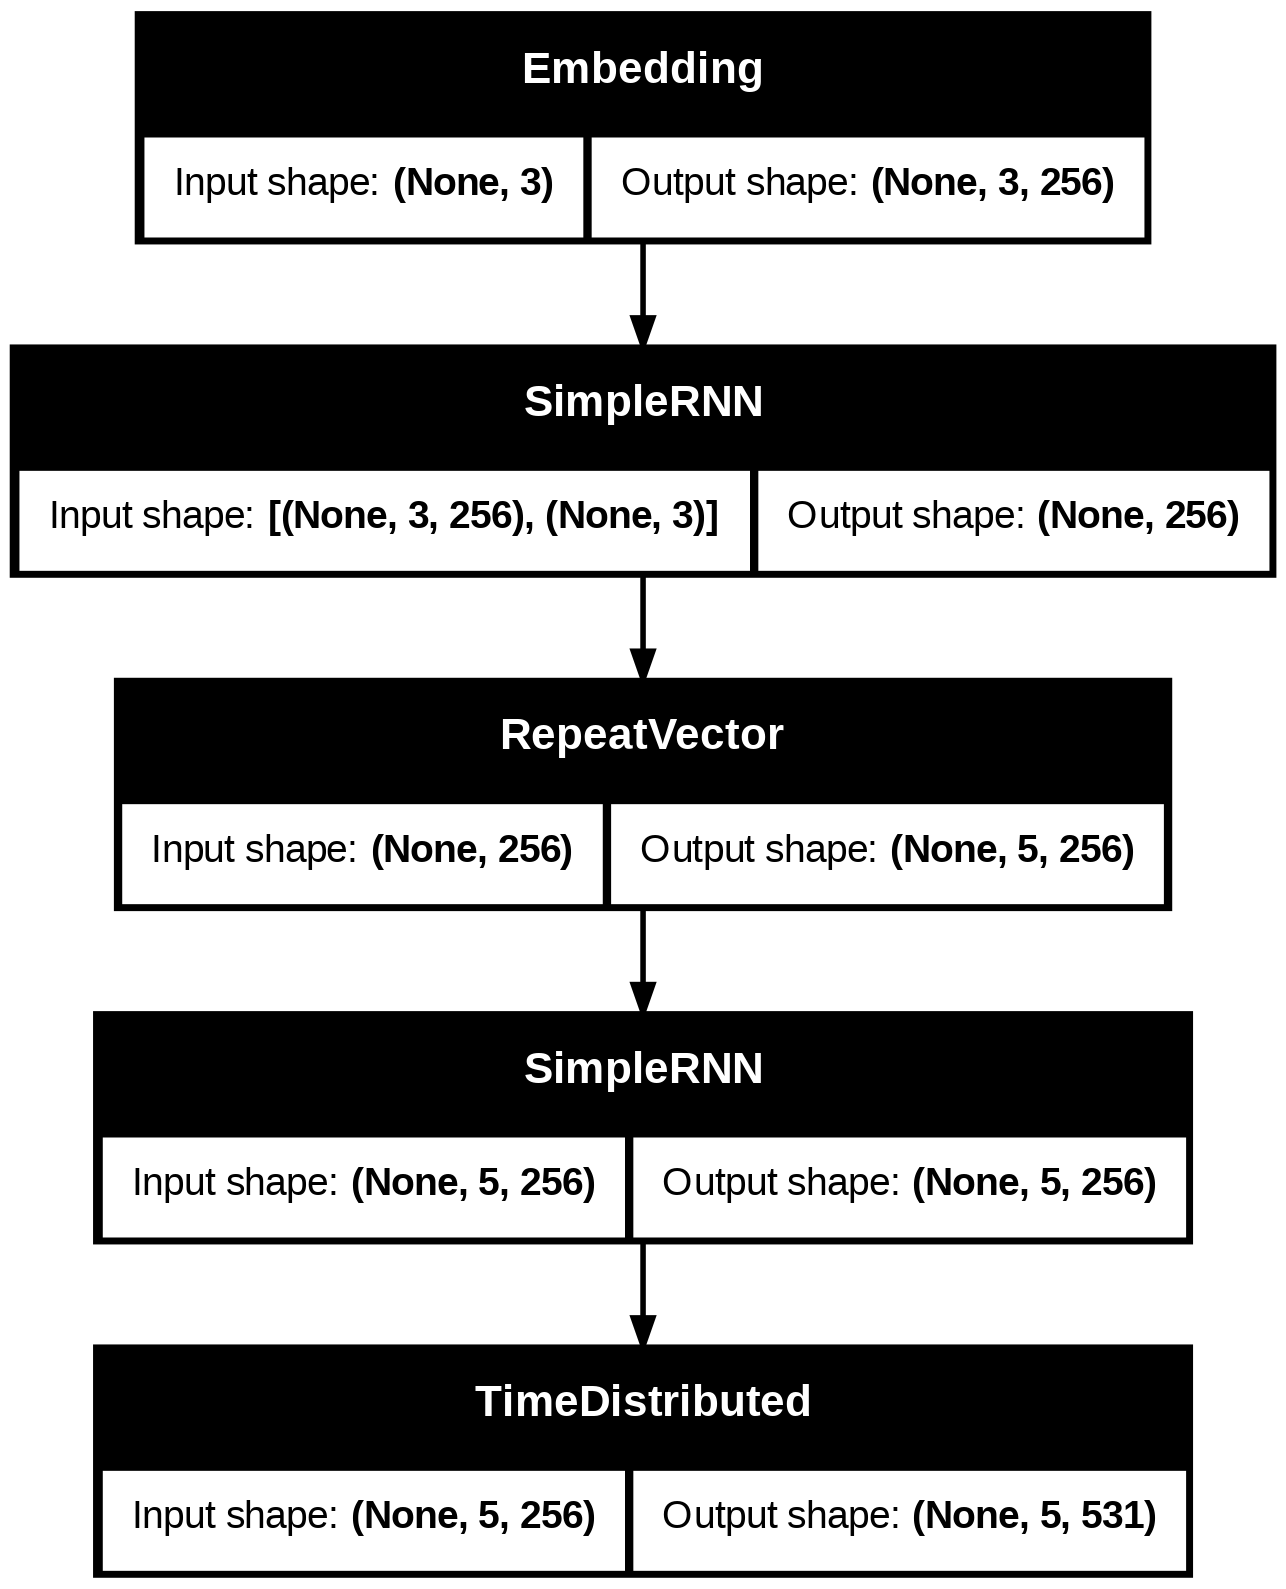

In [67]:
print(model_translate_RNN.summary())

plot_model(model_translate_RNN, to_file='model.png', show_shapes=True)

In [70]:
# Creating the callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=40)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=5,factor=0.1,min_lr=0.001)
mc = ModelCheckpoint('checkpoint/model.keras',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

In [71]:
filename = 'model.h5'

history_1 = model_translate_RNN.fit(trainX, trainY, epochs=30, batch_size=64, validation_split = 0.3, callbacks=[es,rl,mc])

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.0759 - loss: 6.2549
Epoch 1: val_accuracy improved from -inf to 0.38901, saving model to checkpoint/model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 562ms/step - accuracy: 0.0806 - loss: 6.2495 - val_accuracy: 0.3890 - val_loss: 5.8936 - learning_rate: 0.0010
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.3095 - loss: 5.6295
Epoch 2: val_accuracy did not improve from 0.38901
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.3089 - loss: 5.6083 - val_accuracy: 0.3868 - val_loss: 4.9693 - learning_rate: 0.0010
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.3005 - loss: 4.9309
Epoch 3: val_accuracy improved from 0.38901 to 0.41758, saving model to checkpoint/model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.3037 - loss: 4.9017 - val_accuracy: 0.4176 - val_loss: 4.5448 - learning_rate: 0.0010
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3493 - loss: 4.3834 
Epoch 4: 

**Performance Evaluation and Prediction**

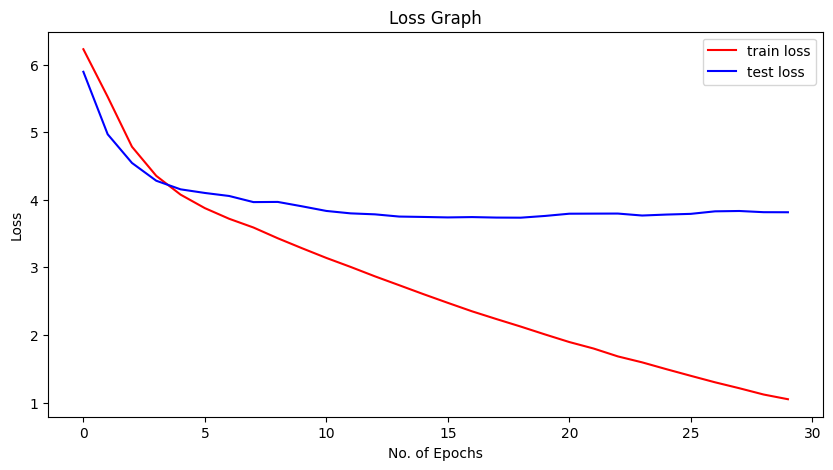

In [72]:
plt.figure(figsize=(10,5))
plt.plot(history_1.history['loss'],'r',label='train loss')
plt.plot(history_1.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

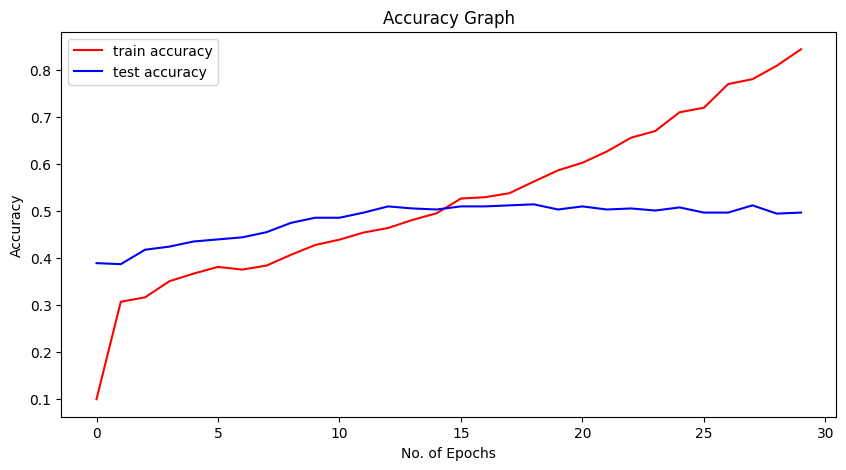

In [73]:
plt.figure(figsize=(10,5))
plt.plot(history_1.history['accuracy'],'r',label='train accuracy')
plt.plot(history_1.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [74]:
results_translate_rnn_test = model_translate_RNN.evaluate(testX, testY)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4514 - loss: 4.4089


In [75]:
results_translate_rnn_train = model_translate_RNN.evaluate(trainX, trainY)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8224 - loss: 1.2802


In [76]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [77]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)